In [1]:
!pip install feature-engine
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from feature_engine.wrappers import SklearnTransformerWrapper
from neuralforecast import NeuralForecast
from neuralforecast.models import TCN
from time import time
import math

## Preprocessing

In [3]:
def nixtla_format_df(data, time_column, targets):
    """
    Converte o DataFrame para o formato esperado pelo Nixtla.
    """
    data = data.rename(columns={time_column: 'ds'})
    # data['ds'] = pd.to_datetime(data['ds'])
    data = data.melt(
        id_vars='ds',
        value_vars=targets,
        var_name='unique_id',
        value_name='y'
    )

    return data


ROOT = "/content/drive/MyDrive/dl-project"
DATA_FILE = f"{ROOT}/data/riser_pq_uni.csv"
SEED = 78

rename_dict = {
    "Time (sec)": "time",
    "Pressure (bar) @x_{99}=56.9453": "pressure_1",
    "Pressure (bar) @x_{105}=60.4141": "pressure_2",
    "Pressure (bar) @x_{109}=62.7266": "pressure_3",
    "Pressure (bar) @x_{114}=65.6172": "pressure_4",
    "Pressure (bar) @x_{119}=68.5078": "pressure_5",
    "Pressure (bar) @x_{124}=71.3984": "pressure_6",
    "Pressure (bar) @x_{128}=73.7109": "pressure_7",
    "Gas mass rate (kg/sec)": "gas_flow_rate",
    "Liquid mass rate (kg/sec)": "liquid_flow_rate",
}

TRAINING_STEPS = 1500
TIME = ['time']
FEATURES = [
    'pressure_1',
    'pressure_2',
    'pressure_3',
    'pressure_4',
    'pressure_5',
    'pressure_6',
    'pressure_7'
]
TARGETS = ['liquid_flow_rate', 'gas_flow_rate']

time_spent = {}
input_size = 187
horizon = 187

In [4]:
data = pd.read_csv(DATA_FILE)
data = (
    data.rename(columns=rename_dict)
    [TIME + TARGETS]
)
data.head()

,time,liquid_flow_rate,gas_flow_rate
0,0.00000,40.085,0.015360
1,0.29493,81.781,0.031328
2,0.59320,61.016,0.024000
3,0.89486,39.192,0.016026
4,1.19880,21.469,0.009156


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


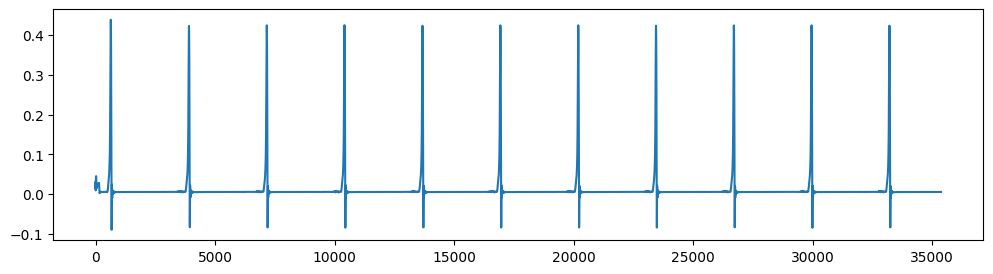

In [6]:
data['gas_flow_rate'].plot(figsize=(12, 3));

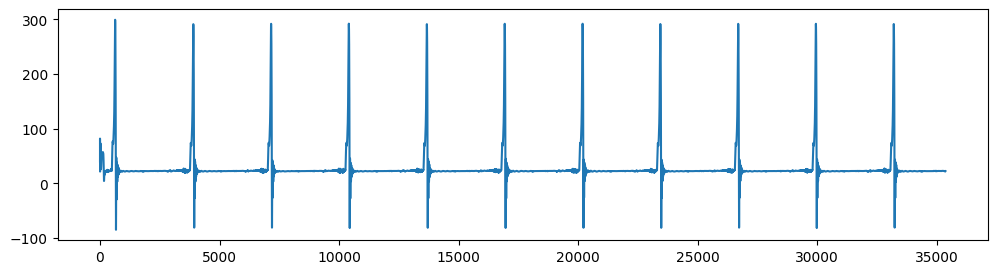

In [7]:
data['liquid_flow_rate'].plot(figsize=(12, 3));

In [8]:
# Converter a série temporal para um espaçamento uniforme de um segundo
data_ = (
    data[TIME + TARGETS]
    .assign(time=np.floor(data['time']).astype(int))
    .groupby(['time'])[TARGETS].mean()
    .reset_index()
    .sort_values(by='time')
)

data_

,time,liquid_flow_rate,gas_flow_rate
0,0,55.518500,0.021678
1,1,26.402000,0.011846
2,2,51.498667,0.026317
3,3,62.201250,0.035752
4,4,68.307667,0.041210
...,...,...,...
2996,2996,22.713000,0.005171
2997,2997,22.696038,0.005170
2998,2998,22.470111,0.005121
2999,2999,22.205667,0.005063


In [9]:
train_data = data_.loc[data_['time'] <= TRAINING_STEPS, :]
test_data = data_.loc[data_['time'] > TRAINING_STEPS, :]

In [10]:
scaler = SklearnTransformerWrapper(MinMaxScaler(), variables=TARGETS)

train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [11]:
# Preparaçao dos dados para usar o Nixtla

train_timeseries = train_data_scaled.rename(columns={'time': 'ds'})
# train_timeseries['ds'] = pd.to_datetime(train_timeseries['ds'])

train_timeseries_long = train_timeseries.melt(
    id_vars='ds',
    value_vars=['gas_flow_rate', 'liquid_flow_rate'],
    var_name='unique_id',
    value_name='y'
)

train_timeseries_long

,ds,unique_id,y
0,0,gas_flow_rate,0.210728
1,1,gas_flow_rate,0.192040
2,2,gas_flow_rate,0.219544
3,3,gas_flow_rate,0.237477
4,4,gas_flow_rate,0.247850
...,...,...,...
2997,1496,liquid_flow_rate,0.413149
2998,1497,liquid_flow_rate,0.421325
2999,1498,liquid_flow_rate,0.430661
3000,1499,liquid_flow_rate,0.440724


### TCN

In [14]:
models = [
    TCN(
        h=horizon,
        input_size=input_size,
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=5,
        random_seed=SEED
    )
]

INFO:lightning_fabric.utilities.seed:Seed set to 78


### Training

In [15]:
start_time = time()
nf = NeuralForecast(
    models=models,
    freq=1
)

nf.fit(df=train_timeseries_long, val_size=horizon)
time_spent['training_time'] = time() - start_time

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder_train    | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 131 K  | train
4 | context_adapter | Linear                     | 35.2 K | train
5 | mlp_decoder     | MLP                        | 16.6 K | train
-----------------------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


In [ ]:
# %load_ext tensorboard

# %tensorboard --logdir lightning_logs/

In [16]:
print("Tempo de treino:", round(time_spent['training_time'], 1), "seconds")

Tempo de treino: 474.3 seconds


### Prediction

In [17]:
# Junta os últimos 'input_size' pontos do treino com os dados de teste
predictions_input_df = pd.concat([train_data_scaled.tail(input_size), test_data_scaled])

In [18]:
# Cria janelas deslizantes do DataFrame para fazer predições
inputs_for_predicions_list = [
    predictions_input_df.iloc[i:i + input_size]
    for i in range(0, len(predictions_input_df) - input_size + 1, horizon)
]

In [ ]:
start_time = time()

forecasts_list = []
for input_df in inputs_for_predicions_list:
    input_df = nixtla_format_df(
        data=input_df,
        time_column=TIME[0],
        targets=TARGETS
    )
    forecast = nf.predict(df=input_df)
    forecasts_list.append(forecast)

time_spent['prediction_time'] = time() - start_time

In [20]:
print("Tempo de predição:", round(time_spent['prediction_time'], 1), "seconds")

Tempo de predição: 1.2 seconds


In [21]:
forecasts_output = pd.concat(forecasts_list)
forecasts_output

,unique_id,ds,TCN
0,gas_flow_rate,1501,0.278508
1,gas_flow_rate,1502,0.285327
2,gas_flow_rate,1503,0.288652
3,gas_flow_rate,1504,0.298222
4,gas_flow_rate,1505,0.306770
...,...,...,...
369,liquid_flow_rate,3179,0.277234
370,liquid_flow_rate,3180,0.277137
371,liquid_flow_rate,3181,0.276790
372,liquid_flow_rate,3182,0.277029


In [22]:
ground_truth = nixtla_format_df(
    data=test_data_scaled,
    time_column=TIME[0],
    targets=TARGETS
)
ground_truth

,ds,unique_id,y
0,1501,liquid_flow_rate,0.459397
1,1502,liquid_flow_rate,0.471283
2,1503,liquid_flow_rate,0.484231
3,1504,liquid_flow_rate,0.496564
4,1505,liquid_flow_rate,0.510421
...,...,...,...
2995,2996,gas_flow_rate,0.179354
2996,2997,gas_flow_rate,0.179351
2997,2998,gas_flow_rate,0.179258
2998,2999,gas_flow_rate,0.179147


In [25]:
TCN_results = pd.merge(
    ground_truth,
    forecasts_output,
    on=['unique_id', 'ds'],
    how='inner'
)
TCN_results

,ds,unique_id,y,TCN
0,1501,liquid_flow_rate,0.459397,0.597344
1,1502,liquid_flow_rate,0.471283,0.624499
2,1503,liquid_flow_rate,0.484231,0.612762
3,1504,liquid_flow_rate,0.496564,0.650765
4,1505,liquid_flow_rate,0.510421,0.686981
...,...,...,...,...
2995,2996,gas_flow_rate,0.179354,0.179112
2996,2997,gas_flow_rate,0.179351,0.176852
2997,2998,gas_flow_rate,0.179258,0.177022
2998,2999,gas_flow_rate,0.179147,0.176746


### Evaluation

In [26]:
# Salvar Resultados
TCN_results.to_csv(f"{ROOT}/results/03-multivariate/TCN.csv", index=False)

In [27]:
y_pred_oil = TCN_results.query('unique_id=="liquid_flow_rate"')['TCN']
y_pred_gas = TCN_results.query('unique_id=="gas_flow_rate"')['TCN']

y_true_oil = TCN_results.query('unique_id=="liquid_flow_rate"')['y']
y_true_gas = TCN_results.query('unique_id=="gas_flow_rate"')['y']

print("MSE - Liquid Flow Rate:", mean_squared_error(y_true_oil, y_pred_oil))
print("MSE - Gas Flow Rate:", mean_squared_error(y_true_gas, y_pred_gas))

print("MAE- Liquid Flow Rate:", mean_absolute_error(y_true_oil, y_pred_oil))
print("MAE- Gas Flow Rate:", mean_absolute_error(y_true_gas, y_pred_gas))

MSE - Liquid Flow Rate: 0.0033414414610981017
MSE - Gas Flow Rate: 0.004732133062732815
MAE- Liquid Flow Rate: 0.018869241301636162
MAE- Gas Flow Rate: 0.014682333966810651


In [28]:
# Média MSE
np.mean([mean_squared_error(y_true_oil, y_pred_oil), mean_squared_error(y_true_gas, y_pred_gas)])

np.float64(0.004036787261915458)

In [29]:
# Média MAE
np.mean([mean_absolute_error(y_true_oil, y_pred_oil), mean_absolute_error(y_true_gas, y_pred_gas)])

np.float64(0.016775787634223407)

In [30]:
# Retornar para os valores originais.

scaled_test_data_wide = (
    nbeats_results
    .pivot(index='ds',
           columns='unique_id',
           values='y')
    .reset_index()
    .rename_axis(None, axis=1)
)

scaled_predicted_data_wide = (
    nbeats_results
    .pivot(index='ds',
           columns='unique_id',
           values='TCN')
    .reset_index()
    .rename_axis(None, axis=1)
)

In [31]:
original_test_data = scaler.inverse_transform(scaled_test_data_wide)
original_predicted_data = scaler.inverse_transform(scaled_predicted_data_wide)

In [32]:
(
    original_predicted_data
    .rename(
        columns={col: f'pred_{col}' for col in original_predicted_data.columns[1:]},
        inplace=True
    )
)

In [33]:
original_scale_results = pd.merge(
    original_test_data,
    original_predicted_data,
    on='ds',
    how='inner'
)
original_scale_results

,ds,gas_flow_rate,liquid_flow_rate,pred_gas_flow_rate,pred_liquid_flow_rate
0,1501,0.059084,91.592333,0.057341,144.485825
1,1502,0.064500,96.149750,0.060928,154.897995
2,1503,0.070651,101.114667,0.062678,150.397858
3,1504,0.076707,105.843333,0.067713,164.969589
4,1505,0.083670,111.156667,0.072210,178.855881
...,...,...,...,...,...
1495,2996,0.005171,22.713000,0.005044,22.329966
1496,2997,0.005170,22.696038,0.003855,20.857418
1497,2998,0.005121,22.470111,0.003944,20.844975
1498,2999,0.005063,22.205667,0.003799,20.839615


In [34]:
y_pred_oil = original_scale_results['pred_liquid_flow_rate']
y_pred_gas = original_scale_results['pred_gas_flow_rate']

y_true_oil = original_scale_results['liquid_flow_rate']
y_true_gas = original_scale_results['gas_flow_rate']

In [35]:
print("=" * 50)
print("         MLPMultivariate Performance")
print("=" * 50)

# RMSE Section
print("\n📊 Root Mean Square Error (RMSE)")
print("-" * 35)
print(f"  Oil   : {math.sqrt(mean_squared_error(y_true_oil, y_pred_oil)):.4f}")
print(f"  Gas   : {math.sqrt(mean_squared_error(y_true_gas, y_pred_gas)):.4f}")

# R² Section
print("\n🎯 R-squared (R²)")
print("-" * 20)
print(f"  Oil   : {r2_score(y_true_oil, y_pred_oil):.4f}")
print(f"  Gas   : {r2_score(y_true_gas, y_pred_gas):.4f}")

# MAE Section
print("\n📈 Mean Absolute Error (MAE)")
print("-" * 32)
print(f"  Oil   : {mean_absolute_error(y_true_oil, y_pred_oil):.4f}")
print(f"  Gas   : {mean_absolute_error(y_true_gas, y_pred_gas):.4f}")

print("=" * 50)

         MLPMultivariate Performance

📊 Root Mean Square Error (RMSE)
-----------------------------------
  Oil   : 22.1645
  Gas   : 0.0362

🎯 R-squared (R²)
--------------------
  Oil   : 0.8400
  Gas   : 0.7701

📈 Mean Absolute Error (MAE)
--------------------------------
  Oil   : 7.2351
  Gas   : 0.0077


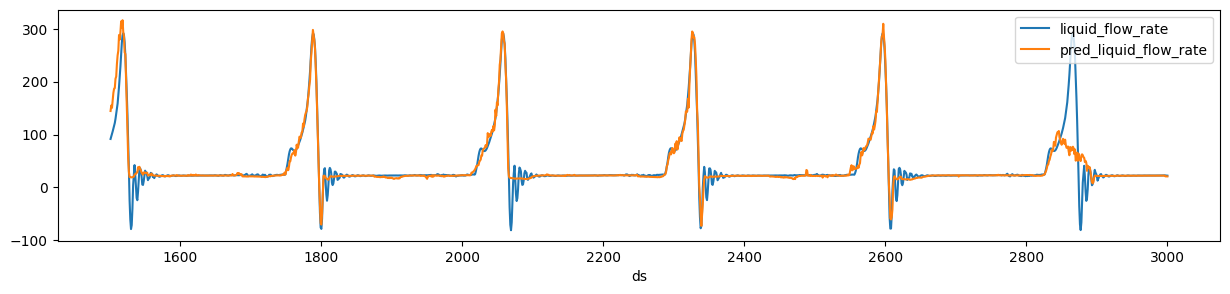

In [36]:
# OIL

(
    original_scale_results
    .plot(x='ds', y=['liquid_flow_rate', 'pred_liquid_flow_rate'], figsize=(15, 3))
);

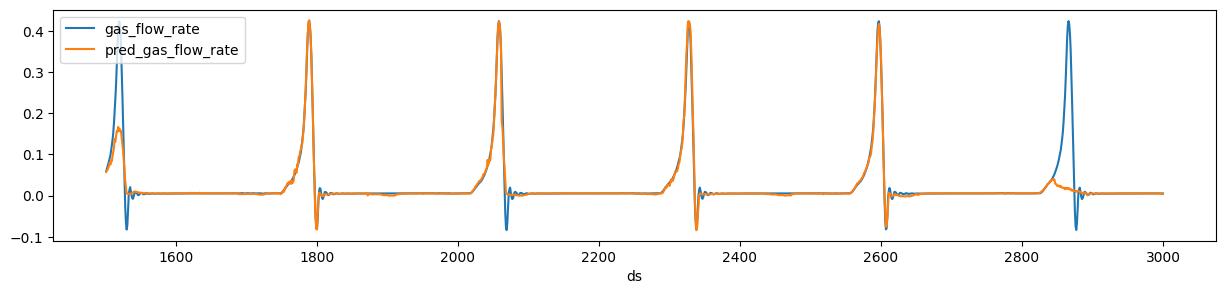

In [37]:
# GAS

(
    original_scale_results
    .plot(x='ds', y=['gas_flow_rate', 'pred_gas_flow_rate'], figsize=(15, 3))
);

In [ ]:
#####################
# Presentation plots
#####################
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Tuple, Dict, Any


def create_pretty_plot(
    data,
    x_col: str,
    y_cols: List[str],
    title: Optional[str] = None,
    x_label: Optional[str] = None,
    y_label: Optional[str] = None,
    figsize: Tuple[float, float] = (15, 6),
    colors: Optional[List[str]] = None,
    line_styles: Optional[List[str]] = None,
    labels: Optional[List[str]] = None,
    style: str = 'seaborn-v0_8-whitegrid',
    legend_loc: str = 'upper right',
    rotate_x_labels: bool = True,
    show_grid: bool = True,
    alpha: float = 0.8,
    linewidth: float = 2,
    save_path: Optional[str] = None,
    **kwargs
) -> plt.Figure:
    """
    Create a prettified time series or line plot with customizable styling.

    Parameters:
    -----------
    data : DataFrame
        The dataset containing the data to plot
    x_col : str
        Column name for x-axis data
    y_cols : List[str]
        List of column names for y-axis data (multiple lines)
    title : str, optional
        Plot title. If None, auto-generates based on y_cols
    x_label : str, optional
        X-axis label. If None, uses x_col
    y_label : str, optional
        Y-axis label. If None, auto-generates
    figsize : Tuple[float, float], default (15, 6)
        Figure size (width, height)
    colors : List[str], optional
        Custom colors for each line. If None, uses default palette
    line_styles : List[str], optional
        Line styles for each line. If None, uses default styles
    labels : List[str], optional
        Custom labels for legend. If None, uses y_cols
    style : str, default 'seaborn-v0_8-whitegrid'
        Matplotlib style to use
    legend_loc : str, default 'upper right'
        Legend location
    rotate_x_labels : bool, default True
        Whether to rotate x-axis labels
    show_grid : bool, default True
        Whether to show grid
    alpha : float, default 0.8
        Line transparency
    linewidth : float, default 2
        Line width
    save_path : str, optional
        Path to save the plot. If None, doesn't save
    **kwargs : Additional arguments passed to plot()

    Returns:
    --------
    plt.Figure : The created figure object

    Examples:
    ---------
    # Basic usage
    fig = create_pretty_plot(
        data=df,
        x_col='date',
        y_cols=['actual', 'predicted']
    )

    # Custom styling
    fig = create_pretty_plot(
        data=df,
        x_col='date',
        y_cols=['actual', 'predicted'],
        title='My Custom Plot',
        colors=['blue', 'red'],
        line_styles=['-', '--'],
        labels=['Actual Values', 'Predicted Values']
    )
    """

    # Set style
    plt.style.use(style)

    # Default colors and line styles
    if colors is None:
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7', '#2F9C0A']

    if line_styles is None:
        line_styles = ['-', '--', '-.', ':', '-', '--']

    if labels is None:
        labels = [col.replace('_', ' ').title() for col in y_cols]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Plot each y column
    for i, y_col in enumerate(y_cols):
        color = colors[i % len(colors)]
        linestyle = line_styles[i % len(line_styles)]
        label = labels[i] if i < len(labels) else y_col

        ax.plot(data[x_col],
                data[y_col],
                linewidth=linewidth,
                label=label,
                color=color,
                alpha=alpha,
                linestyle=linestyle,
                **kwargs)

    # Set title
    if title is None:
        if len(y_cols) == 2 and any('pred' in col.lower() for col in y_cols):
            title = f'{y_cols[0].replace("_", " ").title()}: Actual vs Predicted'
        else:
            title = f'{", ".join([col.replace("_", " ").title() for col in y_cols])}'

    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    # Set axis labels
    if x_label is None:
        x_label = x_col.replace('_', ' ').title()
    if y_label is None:
        y_label = 'Value'

    ax.set_xlabel(x_label, fontsize=12, fontweight='semibold')
    ax.set_ylabel(y_label, fontsize=12, fontweight='semibold')

    # Add legend
    ax.legend(loc=legend_loc,
              frameon=True,
              fancybox=True,
              shadow=True,
              fontsize=11)

    # Rotate x-axis labels if requested
    if rotate_x_labels:
        plt.xticks(rotation=45)

    # Add grid if requested
    if show_grid:
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    # Improve layout
    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # return fig

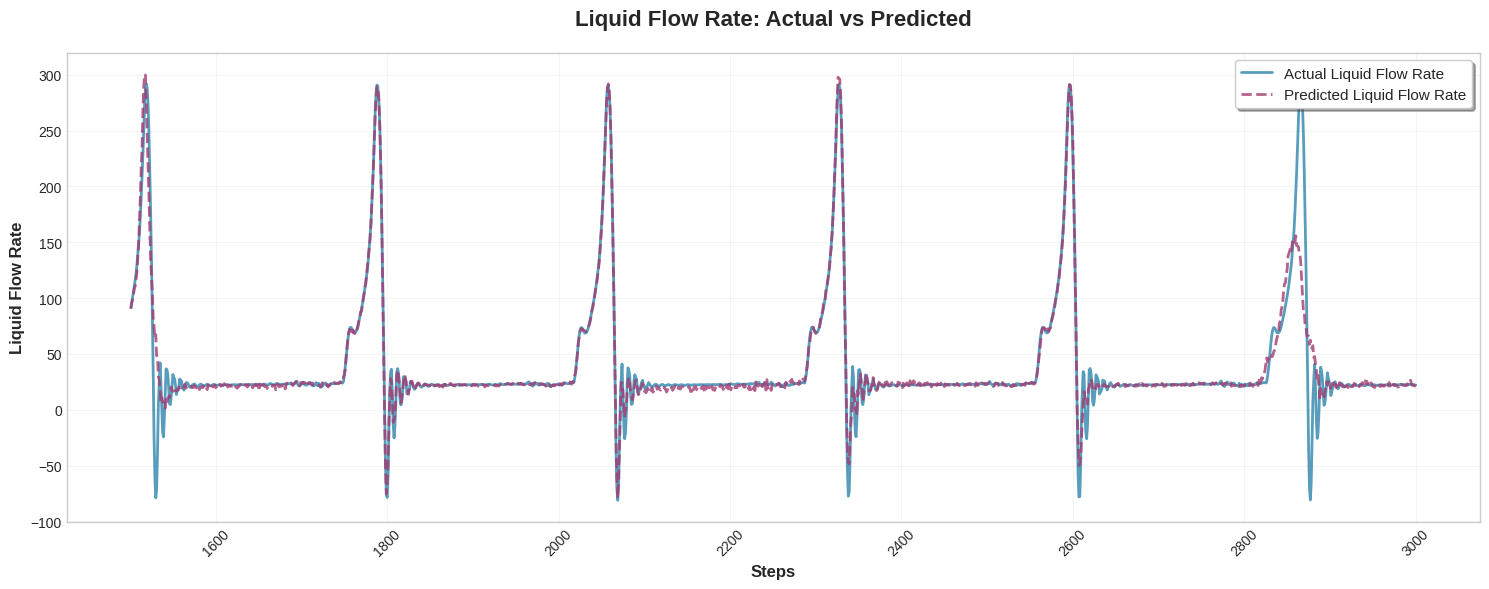

In [ ]:
create_pretty_plot(
    data=original_scale_results,
    x_col='ds',
    y_cols=['liquid_flow_rate', 'pred_liquid_flow_rate'],
    title='Liquid Flow Rate: Actual vs Predicted',
    x_label='Steps',
    y_label='Liquid Flow Rate',
    colors=['#2E86AB', '#A23B72'],
    line_styles=['-', '--'],
    labels=['Actual Liquid Flow Rate', 'Predicted Liquid Flow Rate'],
    figsize=(15, 6),
    alpha=0.8,
    linewidth=2
)

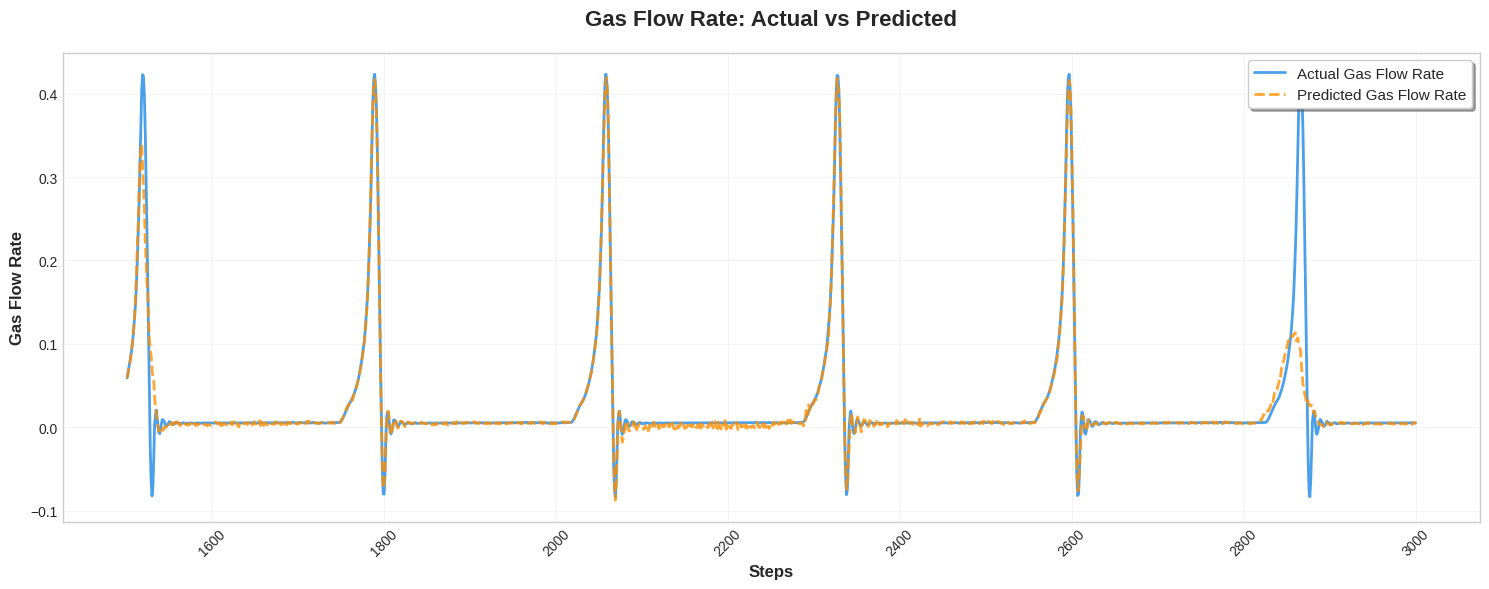

In [ ]:
create_pretty_plot(
    data=original_scale_results,
    x_col='ds',
    y_cols=['gas_flow_rate', 'pred_gas_flow_rate'],
    title='Gas Flow Rate: Actual vs Predicted',
    x_label='Steps',
    y_label='Gas Flow Rate',
    colors=['#1E88E5', '#FF8F00'],
    line_styles=['-', '--'],
    labels=['Actual Gas Flow Rate', 'Predicted Gas Flow Rate'],
    figsize=(15, 6),
    alpha=0.8,
    linewidth=2
)

In [ ]:
# Option 1 (Blue vs Orange):
# ['#1E88E5', '#FF8F00']
# Option 2 (Green vs Red):
# ['#43A047', '#E53935']
# Option 3 (Purple vs Yellow):
# ['#8E24AA', '#FDD835']
# Option 4 (Dark Blue vs Bright Pink):
# ['#1565C0', '#E91E63']
# Option 5 (Forest Green vs Orange):
# ['#2E7D32', '#FF5722']
# Option 6 (Navy vs Lime):
# ['#283593', '#8BC34A']
# Option 7 (Dark Red vs Cyan):
# ['#C62828', '#00BCD4']